In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import os
import pandas as pd
from nltk.parse.generate import generate
from nltk import CFG
from nltk.grammar import Nonterminal
from tqdm import tqdm

from eig.battleship import Parser

from battleship.grammar import BattleshipCFG
from battleship.scoring import compute_score_parallel
from battleship.board import Board

# Battleship grammar

In [3]:
cfg = BattleshipCFG(include_lambdas=False)

In [4]:
# Check that all generated programs are valid
valid, invalid = [], []

for tokens in generate(cfg, n=int(1e6), depth=5, start=Nonterminal('A')):
    program = ' '.join(tokens)
    try:
        Parser.parse(program, enforce_type=False)
        valid.append(program)
    except:
        invalid.append(program)
        print(program, flush=True)

print('Valid programs:', len(valid))
print('Invalid programs:', len(invalid))

Valid programs: 860937
Invalid programs: 0


In [10]:
# Pass `enforce_type=False` to `Parser.parse` to allow all toplevel types
program = Parser.parse("( and TRUE ( touch Red Blue ) )", enforce_type=False)

In [11]:
program.to_dict()

{'type': 'and_op',
 'children': [{'type': 'boolean', 'value': True},
  {'type': 'touch_fn',
   'children': [{'type': 'color', 'value': 2},
    {'type': 'color', 'value': 1}]}]}

# Scoring

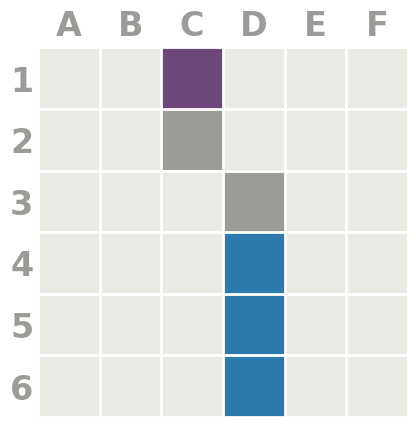

In [11]:
board = Board.from_trial_id(5)
board

In [46]:
scores = compute_score_parallel(programs=valid[:10000], board=board)

100%|██████████| 10000/10000 [00:02<00:00, 4594.35it/s]


In [50]:
df_scores = pd.DataFrame({"program": valid[:10000], "score": scores})
df_scores.sort_values("score", ascending=False).head(10)

,program,score
9594,( and ( == 1 1 ) ( touch Red Blue ) ),0.914766
9592,( and ( == 1 1 ) ( touch Blue Red ) ),0.914766
1979,( and ( and TRUE TRUE ) ( touch Blue Red ) ),0.914766
1981,( and ( and TRUE TRUE ) ( touch Red Blue ) ),0.914766
5620,( and ( == FALSE FALSE ) ( touch Blue Red ) ),0.914766
...,...,...
6690,( and ( == 0 3 ) ( == 5 2 ) ),0.000000
6700,( and ( == 0 3 ) ( == 6 2 ) ),0.000000
6692,( and ( == 0 3 ) ( == 5 4 ) ),0.000000
6693,( and ( == 0 3 ) ( == 5 5 ) ),0.000000


In [51]:
df_scores[df_scores["score"] > 0].sort_values("score", ascending=False)

,program,score
324,( not ( touch Blue Red ) ),0.914766
326,( not ( touch Red Blue ) ),0.914766
657,( and TRUE ( touch Red Blue ) ),0.914766
655,( and TRUE ( touch Blue Red ) ),0.914766
1650,( and ( not FALSE ) ( touch Red Blue ) ),0.914766
1648,( and ( not FALSE ) ( touch Blue Red ) ),0.914766
3967,( and ( or FALSE TRUE ) ( touch Red Blue ) ),0.914766
3965,( and ( or FALSE TRUE ) ( touch Blue Red ) ),0.914766
3303,( and ( or TRUE TRUE ) ( touch Blue Red ) ),0.914766
3305,( and ( or TRUE TRUE ) ( touch Red Blue ) ),0.914766
